# Load Data
Our data here corresponds to N pairs of images. Each image correspond to a matrix of dimension $14x14$. We will use the function generate_pair_sets(N) provided in the Deep Learning course.

# 1. First Approach

This approach could be use as the benchmark since we have already implemented it in other problems for the MNIST dataset. The idea is too predict the class of each image and once we have predicted the class we can compare them as two integers.

# 1.1 Constructing NN

Our first NN for this approach will be a CNN we have to remember than each image is a 14x14 tensor.\
- Our first convolutional layer will have 16 filters of size 3x3 and no stride this implies that after passing by this layer we will have an output of size 12x12x16, then we will use a maxpooling of kernel size 2 and stride 2 then the outout will be of size 6x6x16.
- Our second convolutional layer will have 32 filters of size 3x3 and a max pooling of size 2 and stride 2 then the output will be of size 2x2x32
- The first fully connected layer 


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1]:
!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth                    # Other necessary packages
from oauth2client.client import GoogleCredentials
auth.authenticate_user()                         # Follow prompt in the authorization process
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
your_module = drive.CreateFile({"id": "put_the_sharable_link_here"})   # "your_module_file_id" is the part after "id=" in the shareable link
your_module.GetContentFile("dlc_practical_prologue.py")          # Save the .py module file to Colab VM
import dlc_practical_prologue as prologue

In [4]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
train_input_first_approach =  torch.zeros(size = (2000,1,14,14))
test_input_first_approach = torch.zeros(size = (2000,1,14,14))
k = 0
for i in range(train_input.size(0)):
    train_input_first_approach[k,0]  = train_input[i,0]
    test_input_first_approach[k,0] = test_input[i,0]
    train_input_first_approach[k+1,0]= train_input[i,1]
    test_input_first_approach[k+1,0] =  test_input[i,1]
    k = k + 2

#New output data
train_classes_first_approach =  torch.zeros( size = (2000,1),dtype=torch.long)
test_classes_first_approach = torch.zeros( size =(2000,1),dtype=torch.long)
l = 0
for j in range(train_classes.size(0)):
    train_classes_first_approach[l]= train_classes[j,0]
    test_classes_first_approach[l] = test_classes[j,0]
    train_classes_first_approach[l+1] = train_classes[j,1]
    test_classes_first_approach[l+1] = test_classes[j,1]
    l = l+2



In [0]:
import torch.nn.functional as nnf
train_input_first_approach_t = nnf.interpolate(train_input_first_approach, size=(224, 224), mode='bilinear', align_corners=False)
test_input_first_approach_t = nnf.interpolate(test_input_first_approach, size=(224, 224), mode='bilinear', align_corners=False)

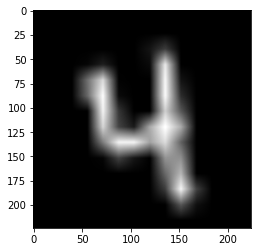

In [7]:
plt.imshow(train_input_first_approach_t[3,0], cmap="gray")
plt.show()

In [8]:
print(len(train_input_first_approach_t))

2000


In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class HandwritingDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, target, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        return (self.data[idx], self.target[idx,0])

In [0]:
train_dataset = HandwritingDataset(train_input_first_approach_t, train_classes_first_approach)
test_dataset = HandwritingDataset(test_input_first_approach_t, test_classes_first_approach)


In [0]:
from torchvision.models.resnet import ResNet, BasicBlock
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

In [0]:
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [0]:
def get_data_loaders(train_batch_size, val_batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=val_batch_size, shuffle=True)
    return train_loader, val_loader

In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [0]:

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 5

model = MnistResNet().to(device)
train_loader, val_loader = get_data_loaders(8, 8)

losses = []
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    total_loss = 0
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    torch.cuda.empty_cache()
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1]
            
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
        
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)
print(losses)
print(f"Training time: {time.time()-start_ts}s")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5, training loss: 2.0744273457527163, validation loss: 1.980241060256958
	     precision: 0.3450
	        recall: 0.4201
	            F1: 0.3596
	      accuracy: 0.4900



Epoch 2/5, training loss: 1.7403688297271729, validation loss: 1.8181198835372925
	     precision: 0.5236
	        recall: 0.5587
	            F1: 0.5224
	      accuracy: 0.6430



Epoch 3/5, training loss: 1.6344844365119935, validation loss: 1.5845736265182495
	     precision: 0.8325
	        recall: 0.8337
	            F1: 0.8231
	      accuracy: 0.8830



Epoch 4/5, training loss: 1.579177421092987, validation loss: 1.532874584197998
	     precision: 0.8976
	        recall: 0.8999
	            F1: 0.8926
	      accuracy: 0.9330


# 2nd Approach

On this approach we will not do classification of images as before. The classification of before was naive for many issues

NameError: ignored